# You have two options:

1.   Upload everything here (all .npz files and the FCN model that the user wants to use)
2.  Connect to Google Drive and go to your work directory


*Please, if you want edit this script. It's recommendable to download it :)*


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# I tend to use my Google Drive directory. The following path only works for I. Cabeza-Gil (First Author of the Paper). Please change accordingly.

In [2]:
cd ./drive/MyDrive/MIAMI_CNNs/

/content/drive/MyDrive/MIAMI_CNNs


In [6]:
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical

import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random

!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm


ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5

In [7]:
from tensorflow import keras

#YOU CAN USE ONE OF THEM
model=keras.models.load_model('UNET_efficientnetb2_v1.h5', compile=False)
#UNET_effb2_v2

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.1, 0.5, 2.4])) 
focal_loss = sm.losses.CategoricalFocalLoss(gamma=4.0)
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


model.compile(optimizer='adam', loss=total_loss, metrics=[metrics])

## If you want to see the model summary

In [8]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 896, 1  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 256, 448, 32  288         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 256, 448, 32  128         ['stem_conv[0][0]']              
                                )                                                             

# We load the S_3*.npz files and we compare the FCN prediction between the manual segmentation

In [9]:
test2=np.load('S_3_test.npz')
test_dataset2,test_ann_cat2 =test2['arr_0'],test2['arr_1']

In [10]:
test_ann=np.load('S_3_annotation.npz')
test_annotation =test_ann['arr_0']

# We are going to see the dimensions of the test_dataset2 (original images) and test_ann_cat2 (annotations)

# Test_dataset are grayscale images while test_ann_cat2 are 512x816x3, refering to the three classes in the image, bg, sclera and CM



In [11]:
%%time
print(np.shape(test_dataset2), np.shape(test_ann_cat2))

(17, 512, 896, 1) (17, 512, 896, 3)
CPU times: user 1.09 ms, sys: 0 ns, total: 1.09 ms
Wall time: 1.1 ms


# Now we do the CM-FCN prediction :)

In [12]:
y_pred=model.predict(test_dataset2, batch_size=4)

5/5 [==============================] - 15s 551ms/step


# We check dimensions. We remove the last dimension to have grayscale images 512x896 (instead of 512x896x1)

In [13]:
y_pred_argmax=np.argmax(y_pred, axis=3)
print(np.shape(y_pred_argmax))
AUX1=np.shape(y_pred)
print(AUX1[0],np.shape(test_annotation))

(17, 512, 896)
17 (17, 512, 896)


# We evaluate the CM-FCN predictions with the manual segmentations


In [14]:
MODEL_EVALUATE=model.evaluate(test_dataset2, test_ann_cat2, batch_size=4)

5/5 [==============================] - 5s 133ms/step - loss: 0.0583 - iou_score: 0.9493 - f1-score: 0.9735


# Now, we will see the segmentation for any random image

In [24]:
import random
AZX=random.randint(1, AUX1[0])
print(AZX)

1


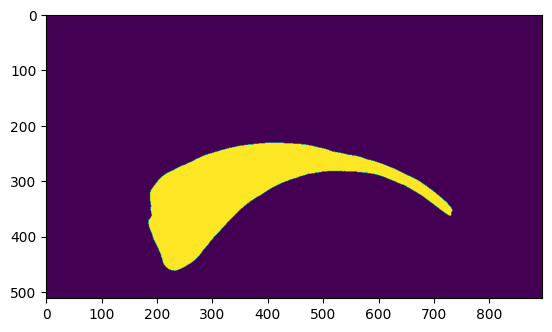

In [16]:
PRUEBA_1=np.round(y_pred[AZX,:,:,:])
plt.imshow(PRUEBA_1[:,:,2])


# IoU


In [17]:
##################################################
n_classes=3
#Using built in keras function
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
#IOU_keras.update_state(val_annotation, y_pred_argmax)
IOU_keras.update_state(test_annotation, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)


Mean IoU = 0.9469846
[[6319327.    8008.   17715.]
 [  11547.  646696.       0.]
 [  73718.       0.  721773.]]
IoU for class1 is:  0.98273987
IoU for class2 is:  0.9706492
IoU for class3 is:  0.8875648


In [18]:
auxiliar_IOU=[IOU_keras.result().numpy(), class1_IoU, class2_IoU, class3_IoU]
print(auxiliar_IOU, MODEL_EVALUATE)

[0.9469846, 0.98273987, 0.9706492, 0.8875648] [0.05831722542643547, 0.9493175745010376, 0.9734630584716797]


In [25]:
image_raw_AUX=test_dataset2[AZX,:,:,:]
image_raw  = np.squeeze(image_raw_AUX)
image_raw=image_raw*255

image_annotation=test_annotation[AZX,:,:]
image_annotation=127.5*image_annotation


image_pred_img=y_pred[AZX]
image_pred_img=np.argmax(image_pred_img, axis=2)
image_pred_X=image_pred_img*127.5

print(np.shape(image_pred_img), np.unique(image_pred_img))

from PIL import Image, ImageDraw, ImageFilter

background = Image.fromarray(image_raw).convert('RGB')
foreground = Image.fromarray(image_pred_X).convert('RGB')

foreground.putalpha(30)
background.paste(foreground, (0, 0), mask=foreground)

(512, 896) [0 1 2]


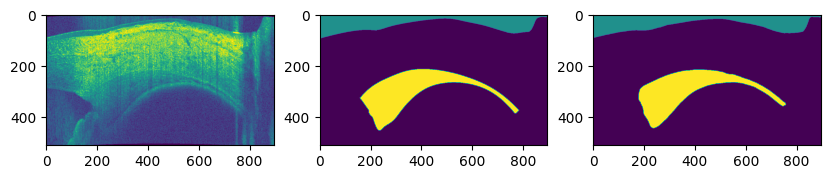

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
ax[0].imshow(image_raw)
ax[1].imshow(image_annotation)
ax[2].imshow(image_pred_X)

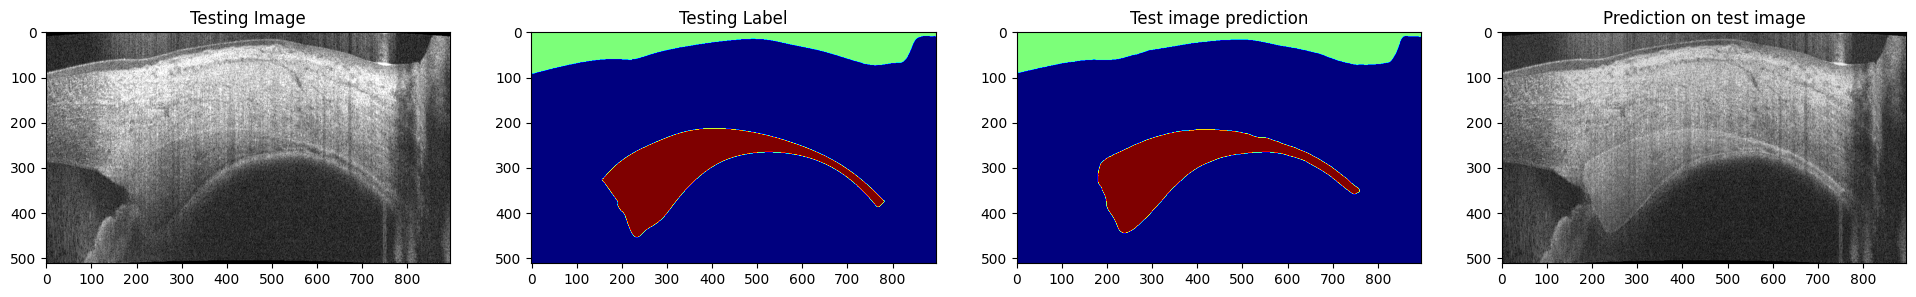

In [27]:
plt.figure(figsize=(24, 16))
plt.subplot(141)
plt.title('Testing Image')
plt.imshow(image_raw, cmap='gray')
plt.subplot(142)
plt.title('Testing Label')
plt.imshow(image_annotation, cmap='jet')
plt.subplot(143)
plt.title('Test image prediction')
plt.imshow(image_pred_X, cmap='jet')
plt.subplot(144)
plt.title('Prediction on test image')
plt.imshow(background, cmap='jet')

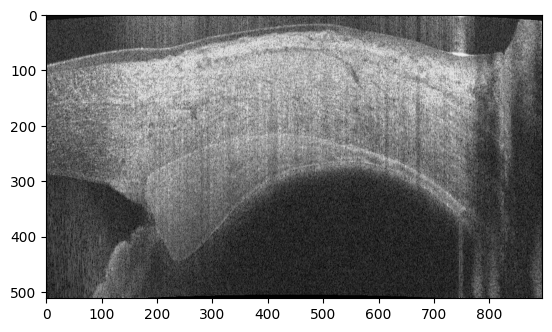

In [28]:
plt.imshow(background)

# We can also compare the two groups:

In [ ]:
A=test_annotation[:,:,1:250]
B=y_pred_argmax[:,:,1:250]

A2=test_annotation[:,:,275:500]
B2=y_pred_argmax[:,:,275:500]


In [ ]:
##################################################
n_classes=3

#Using built in keras function
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
#IOU_keras.update_state(val_annotation, y_pred_argmax)
IOU_keras.update_state(A, B)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)


In [ ]:
##################################################
n_classes=3

#Using built in keras function
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
#IOU_keras.update_state(val_annotation, y_pred_argmax)
IOU_keras.update_state(A2, B2)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)


## If we want to use the CM-FCN for our dataset..


In [ ]:
S_3=np.load('S_0650.npz')
S_3_dataset =S_3['arr_0']

In [ ]:
print(np.shape(S_3_dataset))

(160, 512, 896, 1)


In [ ]:
y_pred=model.predict(S_3_dataset, batch_size=4)

In [ ]:
y_pred_argmax=np.argmax(y_pred, axis=3)
print(np.shape(y_pred_argmax))

(160, 512, 896)


You can save the results to post process them in Matlab..Python5


In [ ]:
from scipy.io import savemat

savemat("S_0650.mat", mdict={'arr': y_pred_argmax})